In [0]:
https://github.com/RenatoBMLR/Facial_Keypoints_Detection/blob/master/Facial_keypoints_detection.ipynb
http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/
https://medium.com/diving-in-deep/facial-keypoints-detection-with-pytorch-86bac79141e4


# Загрузка файлов


In [4]:
# Загрузка файла kaggle.json 
from google.colab import files
files.upload()

# установка kaggle.
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

# скачивание данных
!kaggle competitions download -c facial-keypoints-detection

# распаковка
!unzip training.zip
!unzip test.zip

Saving kaggle.json to kaggle.json
 68% 41.0M/60.1M [00:00<00:00, 69.7MB/s]
100% 60.1M/60.1M [00:00<00:00, 122MB/s] 
 56% 9.00M/16.0M [00:00<00:00, 87.4MB/s]
100% 16.0M/16.0M [00:00<00:00, 102MB/s] 
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 180MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 115MB/s]
Archive:  training.zip
  inflating: training.csv            
Archive:  test.zip
  inflating: test.csv                


# Просмотр данных

In [0]:
#импорт библиотек, использовал pytorch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

from torch import nn, optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

IMG_SIZE = 96

In [0]:
train_data = pd.read_csv('training.csv')

In [0]:
# посмотрел тренеровочные данные
train_data.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7009,7010,7011,7012,7013,7014,7015,7016,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026,7027,7028,7029,7030,7031,7032,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253,69.6807,64.1319,67.4689,65.8029,64.1212,65.2302,66.7376,66.5747,65.2706,66.6072,68.4913,66.6769,66.8504,67.8395,69.2335,65.5956,64.7625,66.0827,64.7186,66.3343,64.553,65.3184,65.4594,65.3769,72.3532,64.1556,64.9563,69.4418,67.5089,65.3781,66.0595,64.7125,66.215,67.0397,64.3325,...,66.6593,65.2627,66.3166,67.9037,66.4645,66.301,67.1193,64.8367,65.3903,62.3849,65.6084,61.9972,64.9061,67.0451,60.2021,72.2262,67.7241,63.0133,67.2779,65.84,69.4632,64.3929,67.3677,68.3209,66.162,66.6519,70.5049,71.2582,69.6162,64.6155,69.2299,63.353,65.7112,67.9293,66.8672,67.4025,66.1344,66.6907,70.9651,66.9383
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213,39.9687,34.29,39.4135,34.7552,36.7403,34.3426,39.8864,37.308,34.9402,38.9381,35.9002,33.9412,35.637,38.5979,40.0215,36.6264,34.9334,37.1537,35.8612,33.7213,36.5242,35.2704,38.9086,38.1289,34.4171,35.2538,35.2355,37.8516,35.7277,35.632,36.8486,34.2681,35.6378,32.372,34.6073,...,40.0731,36.2124,43.8757,41.7278,37.9797,35.7512,37.9044,35.2976,32.2801,32.2983,37.6214,37.2758,41.8102,41.7374,37.7435,40.0464,38.876,36.0536,37.3832,39.1238,41.0387,38.2252,38.0488,36.8326,35.9309,37.3327,35.7834,39.7446,38.0495,35.1653,38.5756,35.6713,38.8435,35.8466,37.3569,31.8426,38.3655,36.8452,39.8537,43.4245
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448,29.1836,29.579,29.356,27.4758,29.4689,28.8027,30.2704,30.4453,33.0227,28.5962,27.8312,30.7136,32.5281,28.0167,25.5508,31.5408,31.8597,27.9783,31.5907,29.0771,32.2198,30.3096,32.0514,29.2155,28.6554,30.7579,29.1167,28.6935,30.6683,30.191,26.5891,30.8571,30.4626,27.1397,32.8899,...,31.0751,29.3557,28.1583,34.0728,30.0619,30.8998,33.7967,31.2624,28.2914,32.7659,31.2643,31.4254,30.5803,29.8587,38.6491,33.0462,29.3992,28.7469,29.1766,29.494,33.8927,29.21,28.6823,29.1977,33.1005,29.2966,32.1823,33.4652,29.494,26.7072,29.4079,33.9521,32.2688,28.6878,30.7509,29.7467,30.4786,31.6664,30.5433,31.0961
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042,37.5634,33.138,39.6217,36.1856,38.3902,33.9378,38.8144,37.308,32.9769,36.3032,37.0221,36.1495,36.5246,36.3977,38.0719,39.3078,37.1915,37.436,39.1194,34.0977,38.0786,38.7026,39.2602,39.5589,32.828,35.2538,35.2355,35.6967,33.6292,34.3974,37.7069,32.2253,37.5031,32.372,37.2519,...,35.5442,42.2983,37.3487,38.4538,39.0829,36.8461,38.2101,40.0939,36.1694,40.8549,38.459,37.9127,36.566,38.177,37.4441,37.8698,37.9297,38.0497,40.6963,42.3241,41.8064,38.6517,37.8144,37.5662,34.9929,37.8341,39.0827,36.6878,42.5967,39.8279,38.3455,40.8164,37.706,41.4525,40.1157,38.6329,39.9502,39.685,40.7723,39.5286
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659,62.8643,57.7972,59.555,58.6522,58.6209,58.7538,61.0176,59.0362,60.5032,61.7145,62.3222,60.3671,61.2288,60.1393,60.2627,59.1474,59.9242,59.8731,59.2879,59.9368,58.4007,60.1705,59.8324,58.4306,63.8785,57.2384,59.201,62.585,61.2136,59.5131,60.0528,58.8754,59.9972,60.3898,59.6305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213,40.1693,35.154,40.4548,37.3293,37.8406,35.5571,39.8864,38.2768,34.9402,38.9381,36.1807,35.2031,36.5246,39.698,40.0215,37.9068,35.9011,38.2828,37.762,34.8497,37.5387,36.2995,39.6119,39.3545,34.9467,36.1483,36.5438,38.2435,36.8932,36.558,37.7069,34.8519,36.5704,33.2301,35.4888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.51

Можно заметить что есть значения NULL. 

In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

Создал две вспомогательные функции чтобы показать keypoints на картинке и показать картинки из dataframe в которых есть, либо нет keypoints

In [0]:
def show_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=24, marker ='.', c='r')

In [0]:
def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):
    plt.figure(figsize=figsize)
    nrows = len(indxs) // ncols + 1
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ').astype(np.float32).reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32).reshape(-1, 2)
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')
        plt.axis('off')
        plt.tight_layout()
        show_keypoints(image, keypoints)
    plt.show()

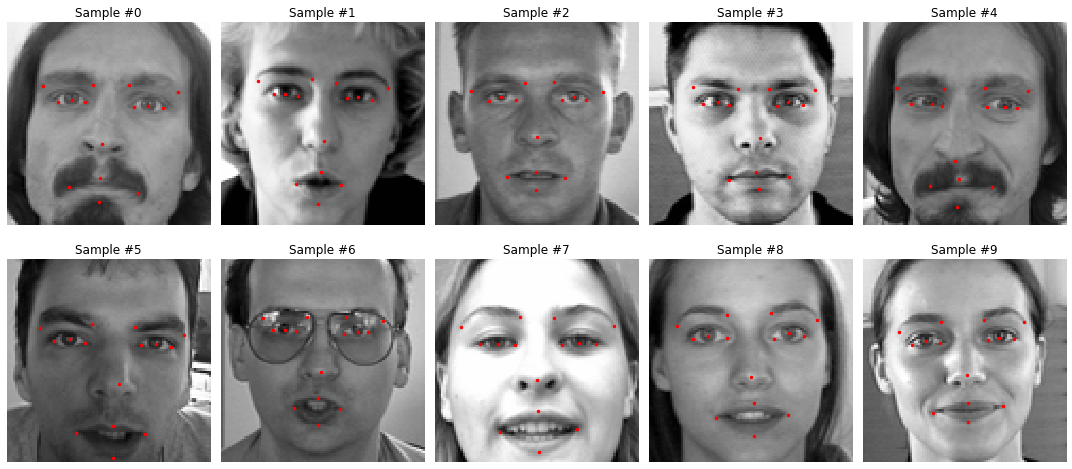

In [0]:
show_images(train_data, range(10))

Посмотрел как выглядят данные с недостоющиемися полями

In [9]:
missing_any_data = train_data[train_data.isnull().any(axis=1)]
missing_any_data.T.tail(10)

,210,350,499,512,810,839,895,1058,1194,1230,1245,1546,1548,1585,1588,1598,1601,1605,1620,1624,1626,1627,1629,1636,1643,1646,1647,1652,1654,1678,1679,1684,1685,1687,1693,1703,1708,1717,1719,1721,...,7009,7010,7011,7012,7013,7014,7015,7016,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026,7027,7028,7029,7030,7031,7032,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048
nose_tip_y,61.2787,62.1639,58.1808,59.5908,57.7843,65.5464,59.7368,63.2299,64.6277,73.573,62.8202,66.0615,68.0685,55.3465,59.0138,60.9704,62.8043,61.9981,55.6728,60.626,57.8225,64.2684,62.726,51.0914,64.1229,60.0399,55.6057,57.6541,54.6764,52.7316,62.0046,57.0419,59.5204,55.501,55.2619,58.2074,60.4316,59.9254,57.5389,60.3862,...,59.4826,65.1205,74.5028,70.1023,63.719,63.4882,63.8899,65.1823,61.301,59.9427,63.5889,65.6185,67.5546,67.847,61.3917,64.7154,69.1574,61.6702,62.784,66.5548,65.8613,66.798,66.887,64.9524,65.9441,66.4145,65.9847,63.3652,70.4148,64.9649,70.8015,59.682,64.096,69.7491,64.9457,67.0291,66.626,67.5152,66.725,73.0333
mouth_left_corner_x,57.8848,57.029,56.9185,64.7701,65.1619,65.8893,62.9833,57.488,66.7683,62.7577,71.4979,70.4921,73.66,68.0135,62.3398,68.8035,65.8804,68.0391,NaN,62.1584,65.9387,62.8782,70.5604,62.6905,61.315,67.9271,60.8548,42.0737,60.9103,76.3099,61.4664,65.4598,66.7477,54.5959,59.6869,63.551,66.4509,59.8181,52.3401,53.5833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouth_left_corner_y,87.4592,86.7783,85.4828,82.8008,83.2227,86.8986,85.9832,86.9412,82.6614,94.3122,81.4839,83.7682,87.2296,71.1333,71.3081,77.111,75.8919,77.1093,NaN,74.2056,85.6152,79.7919,70.832,71.5689,75.7981,78.5186,80.3976,70.4579,70.7232,74.5669,79.9678,76.5339,81.9678,74.5119,85.5829,73.9371,77.9635,79.7718,74.854,76.7137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouth_right_corner_x,34.2931,36.251,28.1978,33.8235,28.7133,27.7611,34.2133,30.7513,21.903,29.3806,25.4452,30.042,31.7304,36.0251,28.4954,30.302,23.6615,32.0946,NaN,27.715,35.4105,26.4346,33.2615,30.8713,29.6731,22.4503,27.0167,19.2974,18.1799,35.1055,31.6909,33.2759,32.1279,24.1187,22.2798,35.7966,32.6617,31.1959,32.2279,44.0719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouth_right_corner_y,85.1578,87.0976,81.9372,82.449,82.4632,88.0423,85.4784,86.32,79.9367,92.6919,78.4135,84.8145,86.3279,79.185,69.7036,77.0383,76.4393,75.6255,NaN,69.5625,85.8783,80.4008,83.7525,71.0422,74.024,76.0963,70.4855,67.6561,60.4037,81.5812,79.0548,75.0127,84.4516,68.6528,75.9246,76.0728,77.4094,79.755,69.9045,77.3135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouth_center_top_lip_x,46.377,45.2018,45.9269,48.2416,47.4206,48.3502,48.3462,45.6744,44.3935,44.9351,47.8594,49.9309,52.695,54.6252,47.0863,50.2744,45.5546,46.1798,29.3244,46.7387,53.7274,46.1788,58.6578,45.9479,44.6241,45.1294,38.0802,26.0566,41.002,60.5872,45.5516,49.2965,50.4125,39.1363,43.9037,49.956,49.6941,44.5835,38.867,48.7204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouth_center_top_lip_y,79.1162,79.1061,75.5544,71.5475,77.7858,85.3734,77.1501,81.6563,78.7847,89.1275,75.5729,80.3618,84.9753,75.5648,73.7042,79.4052,79.6486,78.4677,66.6985,74.4801,83.6414,83.7266,78.0837,71.3714,77.9335,75.9538,75.2707,71.4196,67.4905,73.1437,79.6565,75.2028,81.9776,71.4872,82.0135,74.3834,77.184,79.2264,72.4388,77.999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

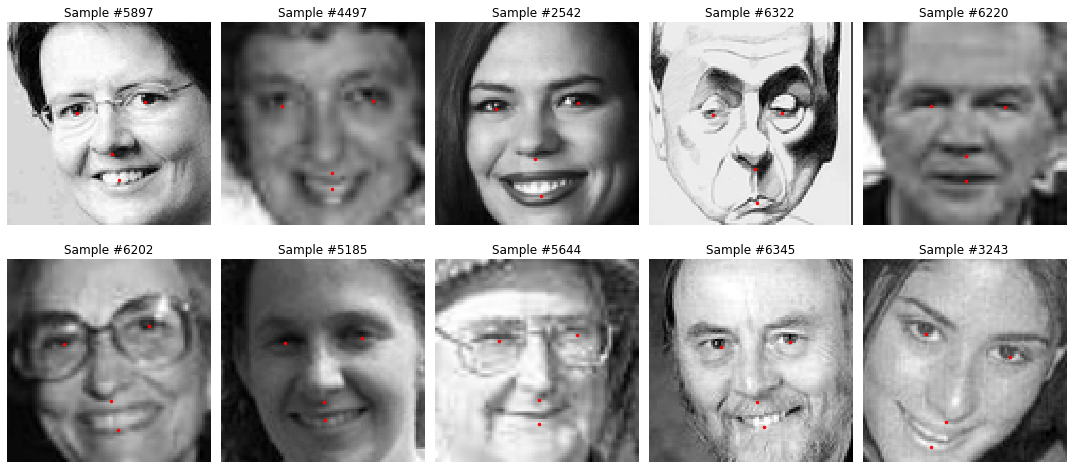

In [10]:
# взял рандомные картинки у которых отсутствуют некоторые поля
idxs = missing_any_data.index
idxs = np.random.choice(idxs, 10)
show_images(train_data, idxs)

In [11]:
# выбрал только те картинки у которых отсутствуют точки нижней губы
missing_bottom_lip_only = train_data[(train_data.mouth_center_bottom_lip_x.isnull() & train_data.mouth_center_top_lip_x.notnull())]
missing_bottom_lip_only.T.tail(10)

,210,350,499,512,810,839,895,1058,1194,1230,1245,1546,1548,2199
nose_tip_y,61.2787,62.1639,58.1808,59.5908,57.7843,65.5464,59.7368,63.2299,64.6277,73.573,62.8202,66.0615,68.0685,74.8911
mouth_left_corner_x,57.8848,57.029,56.9185,64.7701,65.1619,65.8893,62.9833,57.488,66.7683,62.7577,71.4979,70.4921,73.66,83.3142
mouth_left_corner_y,87.4592,86.7783,85.4828,82.8008,83.2227,86.8986,85.9832,86.9412,82.6614,94.3122,81.4839,83.7682,87.2296,93.8066
mouth_right_corner_x,34.2931,36.251,28.1978,33.8235,28.7133,27.7611,34.2133,30.7513,21.903,29.3806,25.4452,30.042,31.7304,44.2838
mouth_right_corner_y,85.1578,87.0976,81.9372,82.449,82.4632,88.0423,85.4784,86.32,79.9367,92.6919,78.4135,84.8145,86.3279,95.5107
mouth_center_top_lip_x,46.377,45.2018,45.9269,48.2416,47.4206,48.3502,48.3462,45.6744,44.3935,44.9351,47.8594,49.9309,52.695,67.7019
mouth_center_top_lip_y,79.1162,79.1061,75.5544,71.5475,77.7858,85.3734,77.1501,81.6563,78.7847,89.1275,75.5729,80.3618,84.9753,94.5484
mouth_center_bottom_lip_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouth_center_bottom_lip_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Image,181 56 47 59 65 71 86 66 32 22 17 7 8 12 13 14...,59 41 36 32 32 31 33 41 55 72 79 70 64 50 52 6...,118 127 122 109 129 154 158 148 147 152 136 13...,194 194 194 191 194 191 191 183 166 151 126 86...,124 124 126 128 131 134 136 141 141 139 138 14...,33 28 25 30 46 67 64 92 169 175 175 183 189 18...,53 59 64 72 85 84 78 81 84 90 96 82 79 95 119 ...,79 85 87 89 88 87 87 51 16 18 17 14 8 5 10 13 ...,255 255 255 255 255 255 254 255 255 150 49 47 ...,254 250 190 99 52 41 38 37 36 32 29 28 28 30 2...,31 31 29 29 30 29 26 28 30 28 32 34 33 33 30 2...,49 54 49 40 35 38 37 33 32 32 41 42 41 38 34 3...,255 254 255 163 74 73 63 54 53 51 44 42 40 35 ...,26 26 33 30 22 25 21 20 18 20 40 54 44 33 33 4...


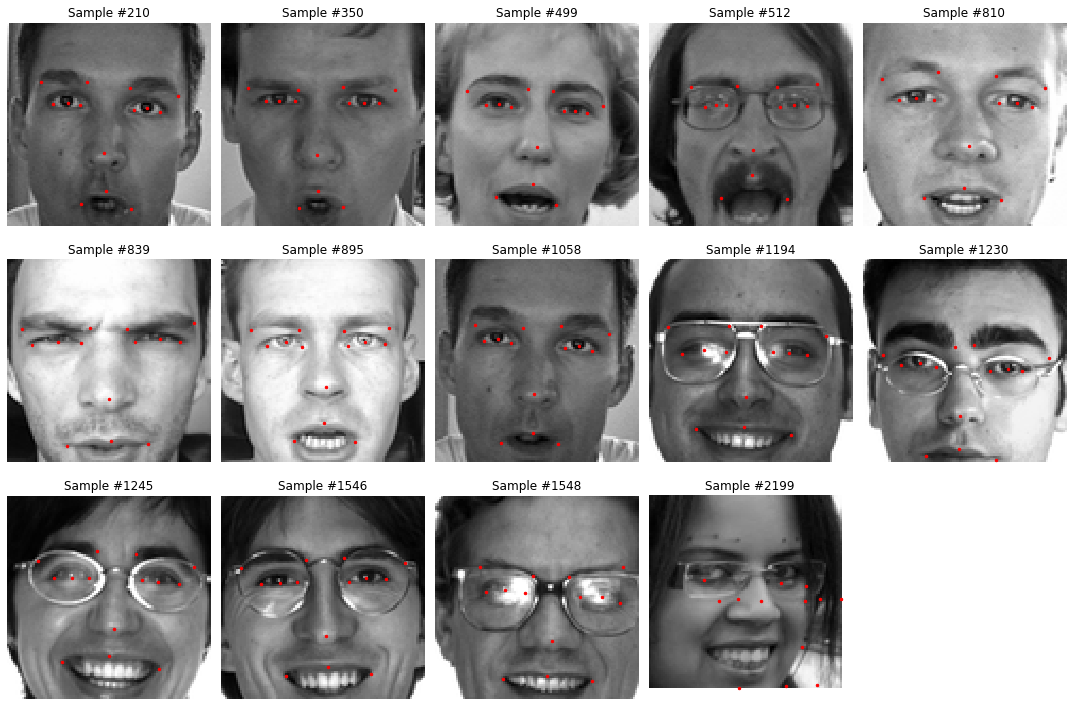

In [12]:
# Посмотрел выбранные картинки
idxs = missing_bottom_lip_only.index
show_images(train_data, idxs)

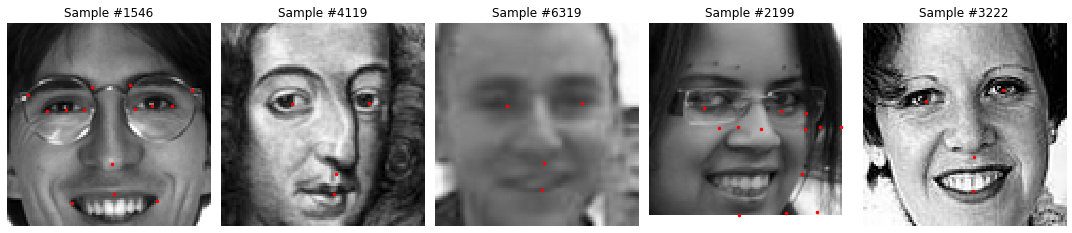

In [13]:
show_images(train_data, [1546, 4119, 6319, 2199, 3222])

Можно заметить что причина отсутсвтия точек качество изображения, не полнота изображения или вовсе не правильное расположение точек.

**Тестовые данные**

In [14]:
test_data = pd.read_csv('test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
ImageId    1783 non-null int64
Image      1783 non-null object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


In [15]:
test_data.head()


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


**Берем только не нулевые данные**

In [16]:
train_df = train_data.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 0 to 2283
Data columns (total 31 columns):
left_eye_center_x            2140 non-null float64
left_eye_center_y            2140 non-null float64
right_eye_center_x           2140 non-null float64
right_eye_center_y           2140 non-null float64
left_eye_inner_corner_x      2140 non-null float64
left_eye_inner_corner_y      2140 non-null float64
left_eye_outer_corner_x      2140 non-null float64
left_eye_outer_corner_y      2140 non-null float64
right_eye_inner_corner_x     2140 non-null float64
right_eye_inner_corner_y     2140 non-null float64
right_eye_outer_corner_x     2140 non-null float64
right_eye_outer_corner_y     2140 non-null float64
left_eyebrow_inner_end_x     2140 non-null float64
left_eyebrow_inner_end_y     2140 non-null float64
left_eyebrow_outer_end_x     2140 non-null float64
left_eyebrow_outer_end_y     2140 non-null float64
right_eyebrow_inner_end_x    2140 non-null float64
right_eyebrow_inner_end_y 

# Data modeling 

In [0]:
#создал Dataset
class FaceKeypointsDataset(Dataset):
    
    def __init__(self, dataframe, train=True, transform=None):
        '''
        Args:
            dataframe (DataFrame): data in pandas dataframe format.
            train (Boolean) : True for train data with keypoints, default is True
            transform (callable, optional): Optional transform to be applied on 
            sample
        '''
        self.dataframe = dataframe
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ')\
                .astype(np.float32).reshape(-1, IMG_SIZE)
        
        if self.train:
            keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None

        sample = {'image': image, 'keypoints': keypoints}
        
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

Добавил функции для нормализации и конвертирования данных в Tensor

In [0]:
class Normalize(object):
    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        return {'image': image / 255., # scale to [0, 1]
                'keypoints': keypoints}
        
class ToTensor(object):

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

Разделение данных на тренеровочные и валидационные

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):
    '''
    
    Args:
        trainset (Dataset): data 
        valid_size (float): validation size, defalut=0.2
        batch_size (int) : batch size, default=128
    ''' 
    
    # определение рандомных тренеровочных индесков которые будут использованы для валидации
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # определение сэплеров для выборки данных по индексам
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # Data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler)
    
    return train_loader, valid_loader

Удаляю данные с нулевыми значениями и подготовил данные для обучения


In [0]:
# дропаю нулевые данные
train_df = train_data.dropna()
test_df = test_data

# размер батча
batch_size = 128
valid_size = 0.2

# нормализация  
tsfm = transforms.Compose([Normalize(), ToTensor()])

# создание тренеровочных и тестовых данных
trainset = FaceKeypointsDataset(train_df, transform=tsfm)
testset = FaceKeypointsDataset(test_df, train=False, transform=tsfm)

# подготовка дата лоадеров
train_loader, valid_loader = prepare_train_valid_loaders(trainset, 
                                                         valid_size,
                                                         batch_size)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# Augementation

In [0]:
class RandomHorizontalFlip(object):
    '''
    Horizontally flip image randomly with given probability
    Args:
        p (float): probability of the image being flipped.
                   Defalut value = 0.5
    '''
    
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        
        flip_indices = [(0, 2), (1, 3),
                        (4, 8), (5, 9), (6, 10), (7, 11),
                        (12, 16), (13, 17), (14, 18), (15, 19),
                        (22, 24), (23, 25)]
        
        image, keypoints = sample['image'], sample['keypoints']
        
        if np.random.random() < self.p:
            image = image[:, ::-1]
            if keypoints is not None:
                for a, b in flip_indices:
                    keypoints[a], keypoints[b]= keypoints[b], keypoints[a]
                keypoints[::2] = 96. - keypoints[::2]
        
        return {'image': image, 
                'keypoints': keypoints}

In [0]:
# взял только данные у которых есть все поля 
aug_train_df = train_data.dropna()
aug_transform = transforms.Compose([RandomHorizontalFlip(p=1.0), 
                                    Normalize(),
                                    ToTensor()])
aug_trainset = FaceKeypointsDataset(aug_train_df, transform=aug_transform)

Dataloader 

In [0]:

batch_size = 128

valid_size = 0.2


aug_train_df = train_data.dropna()


aug_tfms = transforms.Compose([RandomHorizontalFlip(p=0.5),
                                    Normalize(),
                                    ToTensor()])


aug_trainset = FaceKeypointsDataset(aug_train_df, transform=aug_tfms)



aug_train_loader, aug_valid_loader = prepare_train_valid_loaders(aug_trainset, 
                                                                 valid_size,
                                                                 batch_size)

создал CNN модель


In [0]:
class CNN(nn.Module):
    
    
    def __init__(self, outputs=30):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*12*12, 1024)
        self.fc2 = nn.Linear(1024, outputs)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        
        return x

In [0]:
# настроил нейронку под устройство
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(outputs=30)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [0]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Тренеровка модели
    
    Аргументы:
        train_loader (DataLoader): DataLoader для тренеровочных данных
        valid_loader (DataLoader): DataLoader для валидационных данных
        model (nn.Module): модель которую мы тренеруем
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): алгоритм оптимизации
        n_epochs (int): количество эпох
        saved_model (str): путь для сохранения модели
    
    Результат:
        tuple of train_losses, valid_losses
    '''

    
    valid_loss_min = np.Inf # присвоил к минимальному valid_loss бесконечность

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        
        train_loss = 0.0
        valid_loss = 0.0

        model.train() # переключение на тренеровку
        for batch in train_loader:
            optimizer.zero_grad()
            
            output = model(batch['image'].to(device))
            
            loss = criterion(output, batch['keypoints'].to(device))
            
            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()*batch['image'].size(0)

        
        model.eval() # переключение на валидацию
        for batch in valid_loader:
            output = model(batch['image'].to(device))
            
            loss = criterion(output, batch['keypoints'].to(device))
            
            valid_loss += loss.item()*batch['image'].size(0)

        # вывод статистики тренеровочных и валидационных данных 
        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # сохраняю модель если validation_loss стал меньше минимума
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses 

In [51]:
aug_cnn_train_losses, aug_cnn_valid_losses = train(aug_train_loader, aug_valid_loader, model, criterion, 
                                                   optimizer, n_epochs=500, saved_model='cnn.pt')

Epoch: 1 	Training Loss: 2.508987 	Validation Loss: 2.156975
Validation loss decreased (inf --> 2.156975).  Saving model ...
Epoch: 2 	Training Loss: 2.613641 	Validation Loss: 1.767377
Validation loss decreased (2.156975 --> 1.767377).  Saving model ...
Epoch: 3 	Training Loss: 2.462157 	Validation Loss: 2.035218
Epoch: 4 	Training Loss: 2.716367 	Validation Loss: 1.764831
Validation loss decreased (1.767377 --> 1.764831).  Saving model ...
Epoch: 5 	Training Loss: 2.623687 	Validation Loss: 2.459565
Epoch: 6 	Training Loss: 2.698659 	Validation Loss: 1.724934
Validation loss decreased (1.764831 --> 1.724934).  Saving model ...
Epoch: 7 	Training Loss: 2.650788 	Validation Loss: 1.854152
Epoch: 8 	Training Loss: 2.687669 	Validation Loss: 2.100156
Epoch: 9 	Training Loss: 2.625438 	Validation Loss: 1.858980
Epoch: 10 	Training Loss: 2.560691 	Validation Loss: 1.774420
Epoch: 11 	Training Loss: 2.550375 	Validation Loss: 2.322702
Epoch: 12 	Training Loss: 2.839433 	Validation Loss: 1.8

KeyboardInterrupt: ignored

In [0]:
def predict(data_loader, model):
    
    model.eval() # переключаю модель на тестовый режим

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            output = model(batch['image'].to(device)).cpu().numpy()
            
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))
    
    return predictions

def view_pred_df(columns, test_df, predictions, image_ids=range(1,6)):
    # для выводы картинок с точками
    pred_df = pd.DataFrame(predictions, columns=columns)
    pred_df = pd.concat([pred_df, test_df], axis=1)
    pred_df = pred_df.set_index('ImageId')
    show_images(pred_df, image_ids)  

Функция для создание submission файла

In [0]:
def create_submission(predictions, pred_file='preds.csv', sub_file='submission.csv', columns=None):
    
    lookup = pd.read_csv('IdLookupTable.csv')
    if columns == None:
        columns = train_data.columns[:-1]
    preds = pd.DataFrame(predictions, 
                         index=np.arange(1, len(predictions)+1), 
                         columns=columns)
    preds.to_csv(pred_file)
    locations = [preds.loc[image_id, feature_name] 
                 for image_id, feature_name 
                 in lookup[['ImageId', 'FeatureName']].values]
    locations = [location if location < IMG_SIZE else IMG_SIZE for location in locations]
    lookup.Location = pd.Series(locations)
    lookup[['RowId', 'Location']].to_csv(sub_file, index=False)

Получение предсказания и создание submission файла. Вывод тестовых данных с точками

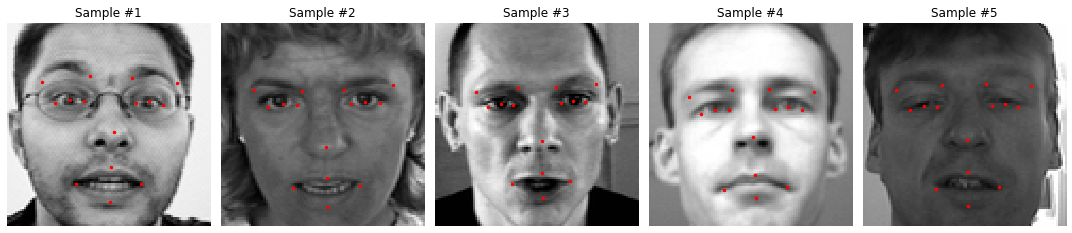

In [52]:
model.load_state_dict(torch.load('cnn.pt'))
predictions = predict(test_loader, model)
create_submission(predictions, 
                  pred_file='preds.csv', 
                  sub_file='submission.csv')
columns = train_df.drop('Image', axis=1).columns
view_pred_df(columns, test_df, predictions)

In [53]:
# submission to kaggle
!kaggle competitions submit -c facial-keypoints-detection -f submission.csv -m "olzhas"

100% 629k/629k [00:05<00:00, 127kB/s]
Successfully submitted to Facial Keypoints Detection